# Generate Synthetic Images

This notebook generates synthetic social movement images using Google Gemini API, combining data from Atropia, World Bank demographics, and visual references.

*Workshop*: AI/ML Pipeline - Synthetic Data Generation; January 23, 2026  
*Platform*: CyVerse Jupyter Lab PyTorch GPU

## Pipeline Overview

1. Load configuration and source data
2. Initialize API client with rate limiting
3. Build prompts from combined data sources
4. Generate images in batches with checkpoints
5. Save images and metadata
6. Summarize results

In [ ]:
%pip install --upgrade diffusers
%pip install transformers
%pip install -U bitsandbytes
%pip install -U accelerate
%pip install ipywidgets
%pip install sentencepiece

## Setup and Imports

In [1]:
import sys
from pathlib import Path
import time
from datetime import datetime
from IPython.display import display, clear_output, Image as IPImage
from tqdm.notebook import tqdm
import glob

#text to image model
import os
import torch
import logging
from huggingface_hub import login
from diffusers import FluxPipeline, FluxTransformer2DModel, StableDiffusionXLPipeline
from transformers import BitsAndBytesConfig

print("imported things")

# Add parent directory to path
parent_dir = Path.cwd().parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

print("bringing in local modules")
# brining in more modeules because of image generation process
# modules are found in the DataCollection/src folder
# from src import config, gemini_client, data_loader, prompt_builder, output_handler
from src import config, data_loader, prompt_builder, output_handler

print("All modules imported successfully")
print(f"Working directory: {Path.cwd()}")

# Load configuration
# DataCollection/src/config.py ... def load_confi()
# using "generation_config.yaml" for setup
cfg = config.load_config()



2026-01-23 01:16:32,638 - src.config - INFO - Logging configured successfully


imported things
bringing in local modules
All modules imported successfully
Working directory: /home/jovyan/data-store/AI-ML_PipelineWorkshop/DataCollection/notebooks


### 1. Load Configuration

Review and adjust generation parameters if needed.
`DataCollection/config/generation_config.yaml`

In [2]:

# see what was loaded from the "generation_config.yaml" 
print("Current Configuration:")
print("=" * 80)
print(f"\nImages to generate: {cfg.generation['num_images']}")
print(f"Batch size: {cfg.generation['batch_size']}")
print(f"Resolution: {cfg.generation['resolution']}")
print(f"Model: {cfg.generation['model']}")
# print(f"If model is gemini-2.5-flash-image, it's AKA Nano Banana")
print(f"\nPrompt style: {cfg.prompts['style']}")
print(f"Prompt complexity: {cfg.prompts['complexity']}")
print(f"\nRate limit: {cfg.rate_limiting['requests_per_minute']} requests/minute")

print("\n" + "=" * 80)

Current Configuration:

Images to generate: 50
Batch size: 10
Resolution: 1K
Model: black-forest-labs/FLUX.1-schnell

Prompt style: realistic
Prompt complexity: medium

Rate limit: 10 requests/minute



### 2. Load Source Data

Load data from all three sources: Atropia, World Bank, and social media references.

In [3]:
print("Loading source data.\n")

data_dir = cfg.get_data_path('raw')

# Initialize data loaders
atropia_loader = data_loader.AtropiaDataLoader(data_dir=data_dir)
worldbank_loader = data_loader.WorldBankDataLoader(data_dir=data_dir)
socialmedia_loader = data_loader.SocialMediaDataLoader(data_dir=data_dir)

# Load datasets
atropia_data = atropia_loader.load_data()
print(f"Loaded {len(atropia_data)} Atropia samples")

worldbank_data = worldbank_loader.load_data()
print(f"Loaded {len(worldbank_data)} World Bank profiles")

socialmedia_data = socialmedia_loader.load_descriptions()
print(f"Loaded {len(socialmedia_data)} visual references")

# Initialize combiner
combiner = data_loader.DataCombiner(
    atropia_loader=atropia_loader,
    worldbank_loader=worldbank_loader,
    socialmedia_loader=socialmedia_loader
)

print("\nAll source data loaded and ready")

2026-01-23 01:16:55,493 - src.data_loader - INFO - Loading Atropia data from /home/jovyan/data-store/AI-ML_PipelineWorkshop/DataCollection/data/raw/atropia_samples.json
2026-01-23 01:16:55,494 - src.data_loader - INFO - Loading World Bank data from /home/jovyan/data-store/AI-ML_PipelineWorkshop/DataCollection/data/raw/worldbank_demographics.csv
2026-01-23 01:16:55,496 - src.data_loader - INFO - Loading visual descriptions from /home/jovyan/data-store/AI-ML_PipelineWorkshop/DataCollection/data/raw/imagepath_labels_descp.json


Loading source data.

Loaded 100 Atropia samples
Loaded 50 World Bank profiles
Loaded 16567 visual references

All source data loaded and ready


## 3. Build Prompts

Generate prompts by combining data from all sources.

In [4]:
print("Building prompts\n")

# Initialize prompt builder
# DataCollection/src/prompt_builder.py > class PromptBuilder
builder = prompt_builder.PromptBuilder(
    style=cfg.prompts['style'],
    complexity=cfg.prompts['complexity'],
    include_temporal=cfg.prompts['include_temporal_context'],
    include_demographics=cfg.prompts['include_demographics'],
    themes=cfg.prompts['themes'],
    settings=cfg.prompts['settings']
)

# Generate combined data samples
num_images = cfg.generation['num_images'] #50
#combiner comes from data_loader.py > class DataCombiner
combined_samples = combiner.sample_combined(n=num_images)

# Build prompts
prompts_data = builder.build_batch_prompts(combined_samples)

print(f"  Built {len(prompts_data)} prompts")
print(f"  Style: {cfg.prompts['style']}")
print(f"  Complexity: {cfg.prompts['complexity']}")

2026-01-23 01:16:57,541 - src.data_loader - INFO - Loading Atropia data from /home/jovyan/data-store/AI-ML_PipelineWorkshop/DataCollection/data/raw/atropia_samples.json
2026-01-23 01:16:57,543 - src.data_loader - INFO - Loading World Bank data from /home/jovyan/data-store/AI-ML_PipelineWorkshop/DataCollection/data/raw/worldbank_demographics.csv
2026-01-23 01:16:57,546 - src.data_loader - INFO - Loading visual descriptions from /home/jovyan/data-store/AI-ML_PipelineWorkshop/DataCollection/data/raw/imagepath_labels_descp.json
2026-01-23 01:16:57,570 - src.data_loader - INFO - Loading Atropia data from /home/jovyan/data-store/AI-ML_PipelineWorkshop/DataCollection/data/raw/atropia_samples.json
2026-01-23 01:16:57,571 - src.data_loader - INFO - Loading World Bank data from /home/jovyan/data-store/AI-ML_PipelineWorkshop/DataCollection/data/raw/worldbank_demographics.csv
2026-01-23 01:16:57,573 - src.data_loader - INFO - Loading visual descriptions from /home/jovyan/data-store/AI-ML_PipelineW

Building prompts



2026-01-23 01:16:57,758 - src.data_loader - INFO - Loading Atropia data from /home/jovyan/data-store/AI-ML_PipelineWorkshop/DataCollection/data/raw/atropia_samples.json
2026-01-23 01:16:57,759 - src.data_loader - INFO - Loading World Bank data from /home/jovyan/data-store/AI-ML_PipelineWorkshop/DataCollection/data/raw/worldbank_demographics.csv
2026-01-23 01:16:57,761 - src.data_loader - INFO - Loading visual descriptions from /home/jovyan/data-store/AI-ML_PipelineWorkshop/DataCollection/data/raw/imagepath_labels_descp.json
2026-01-23 01:16:57,781 - src.data_loader - INFO - Loading Atropia data from /home/jovyan/data-store/AI-ML_PipelineWorkshop/DataCollection/data/raw/atropia_samples.json
2026-01-23 01:16:57,782 - src.data_loader - INFO - Loading World Bank data from /home/jovyan/data-store/AI-ML_PipelineWorkshop/DataCollection/data/raw/worldbank_demographics.csv
2026-01-23 01:16:57,785 - src.data_loader - INFO - Loading visual descriptions from /home/jovyan/data-store/AI-ML_PipelineW

  Built 50 prompts
  Style: realistic
  Complexity: medium


### Preview Sample Prompts

Let's review a few prompts before generation.

In [5]:
print("Sample Prompts:")
print("=" * 80)

for i in range(min(3, len(prompts_data))):
    prompt_info = prompts_data[i]
    print(f"\nPrompt {i+1}:")
    print(f"  {prompt_info['prompt'][:200]}...")
    print(f"\n  Source - Theme: {prompt_info['source_data']['atropia']['theme']}")
    print(f"  Source - Demographics: Age {prompt_info['source_data']['demographics']['age_group']}, "
          f"{prompt_info['source_data']['demographics']['occupation']}")
    print("-" * 80)

Sample Prompts:

Prompt 1:
  photorealistic, high detail, natural lighting. A scene depicting civil society with a digital image with text in spanish, displaying a blue background with white text and a small calendar icon on the ...

  Source - Theme: civil_society
  Source - Demographics: Age 18-24, retail
--------------------------------------------------------------------------------

Prompt 2:
  photorealistic, high detail, natural lighting. A scene depicting government response with a digital image with text in spanish, featuring a building with a green dome and waves in the background, with...

  Source - Theme: government_response
  Source - Demographics: Age 45-54, government
--------------------------------------------------------------------------------

Prompt 3:
  photorealistic, high detail, natural lighting. A scene depicting economic conditions with the image appears to be a digital graphic featuring several screenshots of social media posts and news article...

  Source

### Bring in Model to generate images
***Model 1:*** FLUX.1 [schnell] pulled from HuggingFace. More information on the model can be found here:
- https://huggingface.co/black-forest-labs/FLUX.1-schnell
- https://bfl.ai/blog/24-08-01-bfl

*Repository:* Black Forest Labs. (2024). FLUX [Computer software]. GitHub. https://github.com/black-forest-labs/flux
*Paper:* Black Forest Labs, Batifol, S., Blattmann, A., Boesel, F., Consul, S., Diagne, C., Dockhorn, T., English, J., English, Z., Esser, P., Kulal, S., Lacey, K., Levi, Y., Li, C., Lorenz, D., Müller, J., Podell, D., Rombach, R., Saini, H., . . . Smith, L. (2025). FLUX.1 Kontext: Flow matching for in-context image generation and editing in latent space. arXiv. https://arxiv.org/abs/2506.15742

***Model 2:*** Segmind Stable Diffusion 1B (SSD-1B) pulled from HuggingFace; a smaller model that works with CPU and on local computers. More information on the model can be found here:
- https://huggingface.co/segmind/SSD-1B
- run ``pipe = bring_in_model(GPU = False)``

*Paper:* Gupta, Y., Jaddipal, V. V., Prabhala, H., Paul, S., & von Platen, P. (2024). Progressive knowledge distillation of Stable Diffusion XL using layer level loss. arXiv. https://arxiv.org/abs/2401.02677


In [6]:

def bring_in_model(GPU):
    if GPU:
        # This will pop up a box to paste your token
        login(token = 'your token here')
        # login()

        ###### for GPU
        # Load the FLUX.1 [schnell] model small version 
        # i.e. optimized because there are billions of parameters here and takes up like > 16 RAM
        # Configure the model to load in 4-bit mode (The "Smaller" Version)
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16
        )
        # Load the Transformer specifically with quantization
        transformer = FluxTransformer2DModel.from_pretrained(
            "black-forest-labs/FLUX.1-schnell",
            subfolder="transformer",
            quantization_config=quantization_config,
            torch_dtype=torch.bfloat16
        )
        # use bfloat16 for efficiency as recommended for Flux in huggingface
        # print(f"Loading Model: {cfg.generation['model']}")
        pipe = FluxPipeline.from_pretrained(
            cfg.generation['model'], # "black-forest-labs/FLUX.1-schnell"
            transformer=transformer,
            torch_dtype=torch.bfloat16, 
            low_cpu_mem_usage=True  
        )
        # Optimization: Offload to CPU to save VRAM (Remove if you have 24GB+ VRAM)
        pipe.enable_model_cpu_offload()
        ######

    else:
       
        # SSD-1B is a distilled (smaller) version of SDXL
        pipe = StableDiffusionXLPipeline.from_pretrained(
            "segmind/SSD-1B",
            torch_dtype=torch.float16, 
            use_safetensors=True,
            variant="fp16"
        )
        
        # Move to GPU
        if torch.cuda.is_available():
            pipe.to("cuda")
            print("Model moved to GPU.")
        else:
            print("Warning: Running on CPU. This will be slow.")
        
    return pipe


pipe = bring_in_model(GPU = False)
print("\nModel loaded and ready for generation.")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Model moved to GPU.

Model loaded and ready for generation.


## Generate Synthetic Images
Use either flux.1 schnell with high power gpu or Segmind Stable Diffusion 1B (SSD-1B) for working with less memory to generate images.

Save them to `DataCollection/data/generated`

*This should take about 10-15 minutes*

In [ ]:
# Based on the output handler module,
# This automatically creates folders in DataCollection/data/generated: images/, metadata/, logs/
handler = output_handler.OutputHandler(
    output_dir=cfg.get_output_path(),  # Uses path from generation_config.yaml
    image_format=cfg.output.get('format', 'png'),
    export_csv=True,
    date_organized=True
)

########## Generate Images  ###############
print(f"Starting generation for {len(prompts_data)} images")
print(f"Output directory: {cfg.get_output_path()}\n")

def generate_imgs(flux):
    # Use tqdm for a progress bar in the notebook
    for i, prompt_info in tqdm(enumerate(prompts_data), total=len(prompts_data), desc="Generating Batch"):
        # Get the prompt string built by PromptBuilder
        prompt_text = prompt_info['prompt']
        
        # Create a unique seed for reproducibility
        # You can also use a fixed seed if you want deterministic results
        seed = i  
        generator = torch.Generator("cpu").manual_seed(seed)
        
        if flux:
            #Generate Image with Flux
            # Note: Flux Schnell works best with guidance_scale=0.0 and roughly 4 steps
            image = pipe(
                prompt_text,
                guidance_scale=0.0,
                num_inference_steps=4, 
                max_sequence_length=256,
                height=1024, # Standard resolution for Flux
                width=1024,
                generator=generator
            ).images[0]
        else:
            # SSD-1B / SDXL Generation Call
            image = pipe(
                prompt_text,
                num_inference_steps=25,   # Standard for SDXL
                guidance_scale=7.5,       # Standard for SDXL
                width=1024,
                height=1024,
                generator=generator
            ).images[0]
        
        # Save Image & Metadata using OutputHandler
        # We pass the full prompt_info so all source data (Atropia/Demographics) is saved in the JSON
        saved_path = handler.save_image(
            image=image,
            index=i,
            prompt_data=prompt_info
        )
    return saved_path, handler


saved_path, handler = generate_imgs(flux = False)
# Save the final log of the generation session
log_path = handler.save_generation_log()
print(f"\nGeneration complete. Log saved to: {log_path}")

## Image Outputs
Let's take a look at what the image outputs are ... so bad
But we can go into the prompts later to see how to change things around
- New workshop idea --> Prompt Engineering for synthetic image generation

Reviewing last 3 generated images:

File: sm_20260123_0047.png


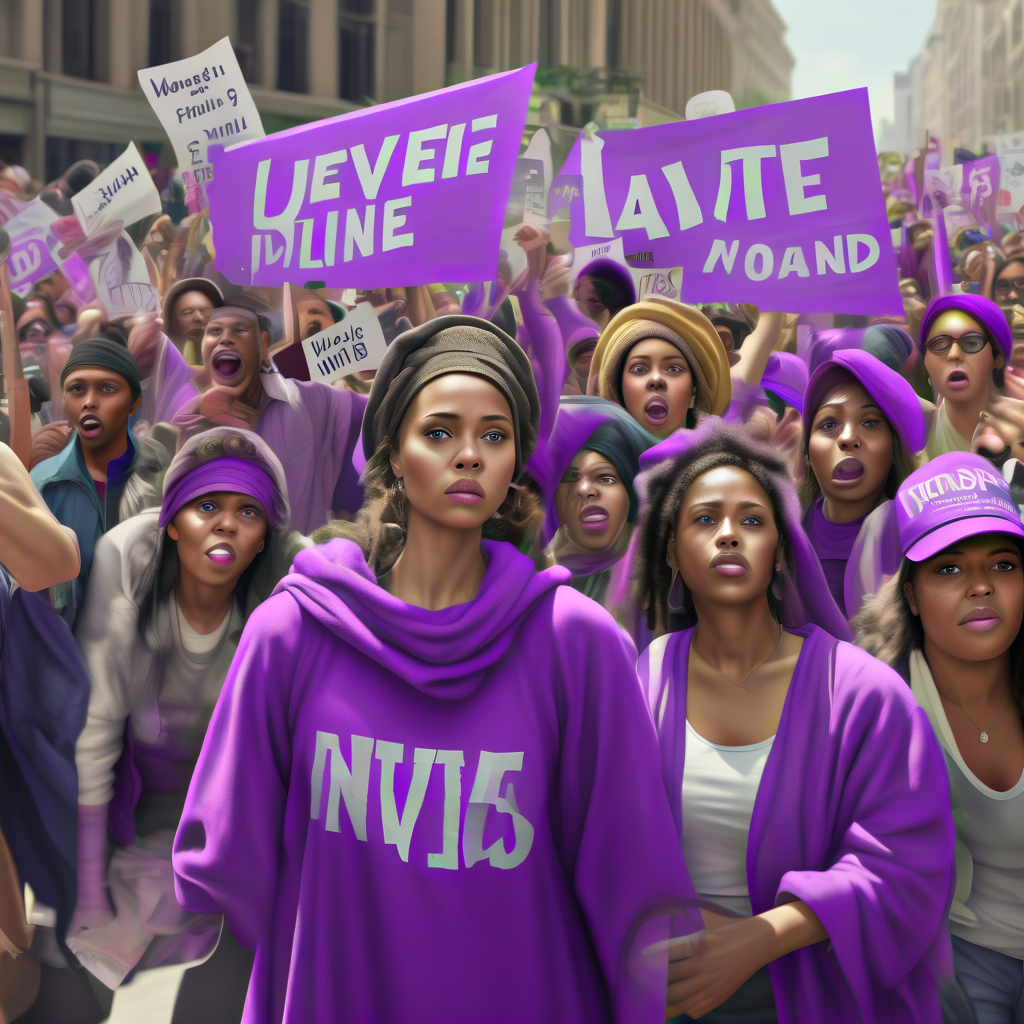

Prompt Segment: photorealistic, high detail, natural lighting. A scene depicting political unrest with a group of pe...

File: sm_20260123_0048.png


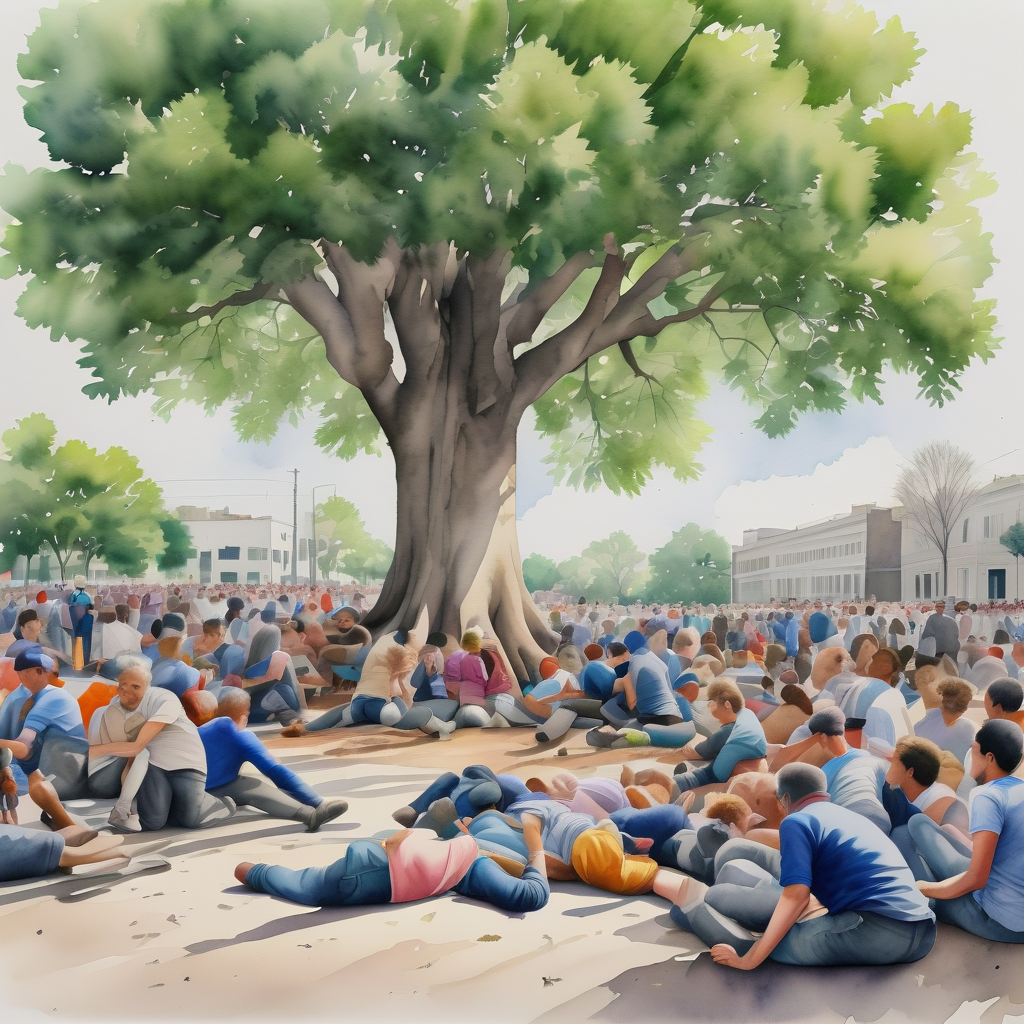

Prompt Segment: photorealistic, high detail, natural lighting. A scene depicting social movements with a watercolor ...

File: sm_20260123_0049.png


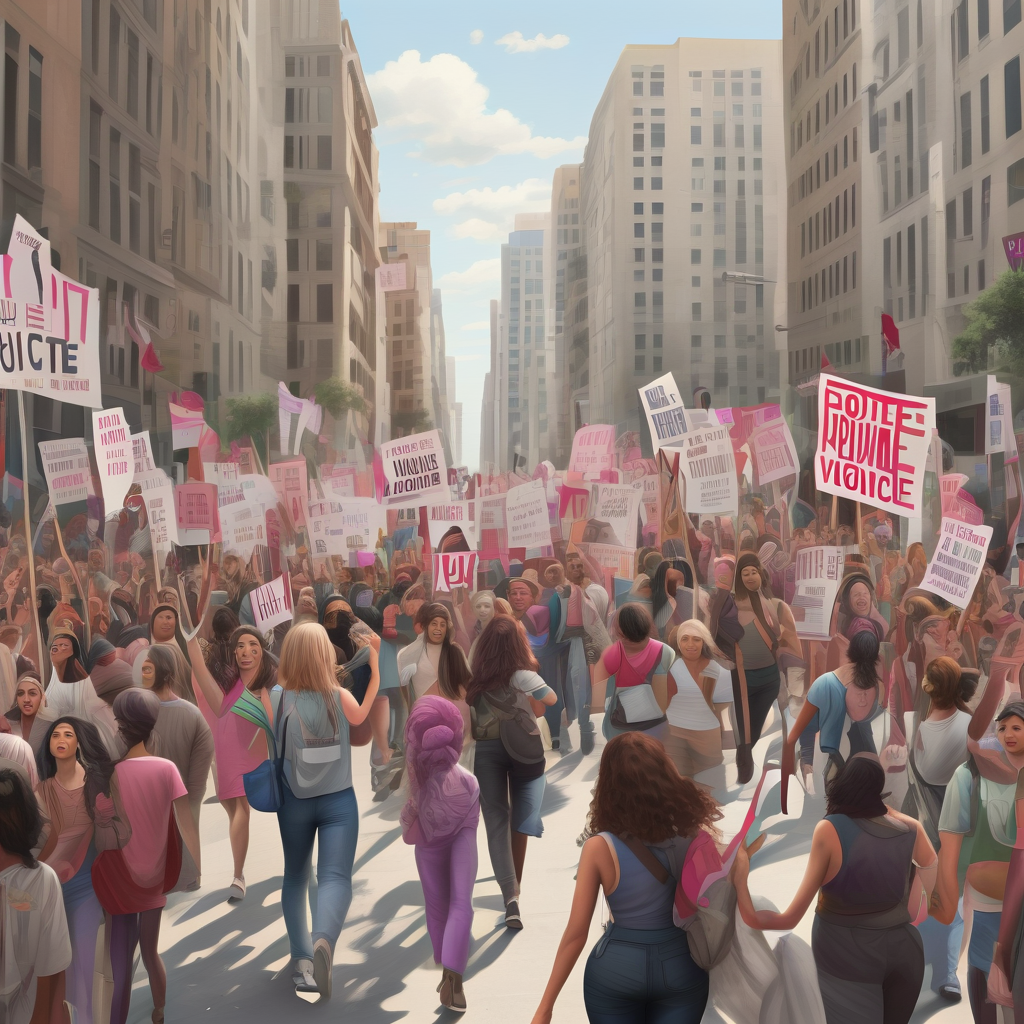

Prompt Segment: photorealistic, high detail, natural lighting. A scene depicting elections with a group of people, m...


--- Batch Summary ---
Total Images Saved: 50
Full Output Path: /home/jovyan/data-store/AI-ML_PipelineWorkshop/DataCollection/data/generated


In [ ]:
### Review Image Results #########

print("Reviewing last 3 generated images:\n")

# Get the directory where images were just saved
# (handler.images_dir is a Path object from your output_handler.py)
image_files = sorted(list(handler.images_dir.glob(f"*.{handler.image_format}")))

if image_files:
    # Show the last 3 images
    recent_images = image_files[-5:]
    
    for img_path in recent_images:
        print(f"File: {img_path.name}")
        # Display image with a constrained width for notebook readability
        display(IPImage(filename=str(img_path), width=400))
        
        # Optional: Print the prompt associated with it (requires reading the metadata file)
        # This assumes standard naming convention from output_handler (base_filename + _metadata.json)
        meta_filename = img_path.stem + "_metadata.json"
        meta_path = handler.metadata_dir / meta_filename
        if meta_path.exists():
            import json
            with open(meta_path, 'r') as f:
                meta = json.load(f)
                print(f"Prompt Segment: {meta['prompt'][:100]}...\n")
else:
    print("No images found to display.")

# Print summary from handler
summary = handler.get_summary()
print("\n--- Batch Summary ---")
print(f"Total Images Saved: {summary['images_saved']}")
print(f"Full Output Path: {summary['output_directory']}")